In [4]:
import pickle
import numpy as np
from sklearn.preprocessing import RobustScaler,MinMaxScaler
X_ppg,X_qual,X_acc,y_rr,y_respiration,y_inspiration,y_expiration,groups,X_respiration,y_activity,y_label = pickle.load(open('../../affect-recognition/data/tabular_data_8.p','rb'))

In [5]:
from sklearn.preprocessing import OneHotEncoder
index = np.where((y_activity!=0)&(y_activity!=3)&(y_activity!=6)&(y_activity!=8))[0]
# index = np.where((y_activity==1))[0]
X_acc = X_acc[index]
y_activity = y_activity[index]
groups = groups[index]
y_activity = OneHotEncoder().fit_transform(y_activity.reshape(-1,1)).todense()
X_fft = np.fft.fft(X_acc[:,:,:],axis=1)
X_fft_real = X_fft.real
X_fft_imag = X_fft.imag
X_fft = np.concatenate([X_fft_real,X_fft_imag],axis=2)
max_value = X_fft.max()
X_fft = X_fft/max_value
X_fft = X_fft.reshape(-1,256*6)

/home/azim/.local/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [6]:
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torchvision import transforms,datasets
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchsummary import summary
# from tensorboardX import SummaryWriter
X_fft.shape
# y_activity = np.array(np.argmax(y_activity,axis=1)).reshape(-1,1)
# X_fft = X_fft[np.where(y_activity[:,-1]==1)[0]]
# y_activity = y_activity[np.where(y_activity[:,-1]==1)[0]]

X_fft.shape,y_activity.shape

((22832, 1536), (22832, 5))

In [7]:
import torch.utils.data as data_utils
batch_size = 128
train = data_utils.TensorDataset(torch.from_numpy(X_fft), torch.from_numpy(y_activity.reshape(-1,1,5)))
data_loader = data_utils.DataLoader(train, batch_size=batch_size, shuffle=True)

In [35]:
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=.02):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)
# class Discriminator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.n_timesteps = 256
#         self.n_channels = 6
#         self.model_temp = nn.Sequential(
#             nn.ConvTranspose1d(1,1,kernel_size=8,dilation=4,padding=1,output_padding=1),
#             nn.ConvTranspose1d(1,1,kernel_size=9,dilation=4,padding=0,output_padding=0),
#             nn.ConvTranspose1d(1,1,kernel_size=10,dilation=4,padding=0,output_padding=1,stride=2),
#         )
        
#         self.model_temp2 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(164,self.n_timesteps//4),
#             nn.Linear(self.n_timesteps//4,self.n_timesteps),
#             nn.ReLU(),
#             nn.Linear(self.n_timesteps,self.n_timesteps*2),
#             nn.ReLU(),
#             nn.Linear(self.n_timesteps*2,self.n_timesteps*6)
#         )
        
#         self.model_temp3 = nn.Sequential(
#             nn.Conv1d(12,100,9,1,padding=4),
#             nn.MaxPool1d(2),
#             nn.Tanh(),
#             nn.Conv1d(100,200,9,1,padding=4),
#             nn.MaxPool1d(4),
#             nn.Tanh(),
#             nn.Conv1d(200,300,9,1,padding=4),
#             nn.Flatten(),
#             nn.Linear(32*300,30),
# #             nn.ELU(),
#             nn.Linear(30,1),
#             nn.Sigmoid()           
#         )
    
#     def forward(self,x, labels):
#         labels = labels.view(labels.size(0),1,5)
#         y = self.model_temp(labels.float())
#         y = self.model_temp2(y.view(y.size(0),164))
#         y = y.view(y.size(0),6,self.n_timesteps)
#         x = x.view(x.size(0),self.n_channels,self.n_timesteps)
#         z = torch.cat([x.double(),y.double()],1)
#         z = self.model_temp3(z.float())
#         return z.squeeze()



class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_timesteps = 256
        self.n_channels = 6
        self.std = .002
        self.model_temp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5,self.n_timesteps*self.n_channels)
        )
        
        self.model_temp3 = nn.Sequential(
            nn.Conv1d(12,50,9,1,padding=4),
            nn.LeakyReLU(),
            nn.MaxPool1d(2),
#             nn.Dropout(.4),
            nn.LeakyReLU(),
            nn.Conv1d(50,25,9,1,padding=4),
            nn.MaxPool1d(4),
#             nn.Dropout(.4),
            nn.LeakyReLU(),
            nn.Conv1d(25,10,9,1,padding=4),
            nn.MaxPool1d(2),
#             nn.Dropout(.2),
            nn.Flatten(),
            nn.Linear(160,10),
#             nn.LeakyReLU(),
            nn.Linear(10,1),
            nn.Sigmoid()           
        )
    
    def forward(self,x, labels):
        x = x + torch.randn(x.size()).cuda() * self.std
        labels = labels + torch.randn(labels.size()).cuda() * self.std
        labels = labels.view(labels.size(0),5)
        y = self.model_temp(labels.float())
        y = y.view(y.size(0),self.n_channels,self.n_timesteps)
        x = x.view(x.size(0),self.n_channels,self.n_timesteps)
        z = torch.cat([x.double(),y.double()],1)
        z = self.model_temp3(z.float())
        return z.squeeze()


# class Generator(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.n_timesteps = 256
#         self.n_channels = 6
#         self.model_temp = nn.Sequential(
#             nn.ConvTranspose1d(1,1,kernel_size=8,dilation=4,padding=1,output_padding=1),
#             nn.ConvTranspose1d(1,1,kernel_size=9,dilation=4,padding=0,output_padding=0),
#             nn.ConvTranspose1d(1,1,kernel_size=10,dilation=4,padding=0,output_padding=1,stride=2),
#         )
#         self.model_temp2 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(164,self.n_timesteps//4),
#             nn.Linear(self.n_timesteps//4,self.n_timesteps),
# #             nn.Tanh(),
# #             nn.Linear(self.n_timesteps,self.n_timesteps*2),
# #             nn.Tanh(),
#             nn.Linear(self.n_timesteps,self.n_timesteps*6)
#         )
#         self.model_temp3 = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(354,self.n_timesteps//4),
# #             nn.Linear(self.n_timesteps//4,self.n_timesteps),
# #             nn.Tanh(),
# #             nn.Linear(self.n_timesteps,self.n_timesteps*2),
# #             nn.Tanh(),
#             nn.Linear(self.n_timesteps//4,self.n_timesteps*6)
#         )
        
#         self.model_temp4 = nn.Sequential(
#             nn.Conv1d(12,100,9,1,padding=4),
#             nn.Tanh(),
#             nn.Conv1d(100,200,9,1,padding=4),
#             nn.Tanh(),
#             nn.Conv1d(200,300,9,1,padding=4),
#             nn.Tanh(),
#             nn.Conv1d(300,6,9,1,padding=4),
#             nn.Tanh()
            
#          )
    
#     def forward(self,x,labels):
# #         print(labels.shape,x.shape)
#         labels = labels.view(labels.size(0),1,5)
#         y = self.model_temp(labels.float())
#         x = x.view(x.size(0),1,100)
#         x = self.model_temp(x)
#         x = self.model_temp3(x)
#         x = x.view(x.size(0),self.n_channels,self.n_timesteps)
#         y = self.model_temp2(y.view(y.size(0),164))
#         y = y.view(y.size(0),self.n_channels,self.n_timesteps)
#         y = torch.cat([x,y],1)
#         y = self.model_temp4(y)
#         y = y.view(y.size(0),self.n_timesteps,self.n_channels)
#         return y.squeeze()


class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.n_timesteps = 256
        self.n_channels = 6
        self.std = .002
        self.model_temp = nn.Sequential(
            nn.Flatten(),
            nn.Linear(5,self.n_timesteps*self.n_channels),
            nn.LeakyReLU(.2),
        )
        
        self.model_temp1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100,self.n_timesteps*self.n_channels*2),
            nn.LeakyReLU(.2)
        )
        
        self.model_temp2 = nn.Sequential(
            nn.Conv1d(12,12,9,1,padding=4),
            nn.LeakyReLU(.2)
        )
        
        self.model_temp3 = nn.Sequential(
            nn.Conv1d(6,6,9,1,padding=4),
            nn.LeakyReLU(.2)
        )
        
        self.model_temp4 = nn.Sequential(
            nn.Conv1d(18,100,9,1,padding=4),
            nn.LeakyReLU(.2),
#             nn.BatchNorm1d(100),
            nn.Conv1d(100,100,9,1,padding=4),
#             nn.BatchNorm1d(100),
            nn.Tanh(),
            nn.Conv1d(100,6,9,1,padding=4),
            nn.Tanh()
         )
    
    def forward(self,x,labels):
        labels = labels + torch.randn(labels.size()).cuda() * self.std
        x = x + torch.randn(x.size()).cuda() * self.std
        labels = labels.view(labels.size(0),1,5).float()
        y = self.model_temp(labels)
        y = y.view(y.size(0),self.n_channels,self.n_timesteps)
        x = x.view(x.size(0),100)
        x = self.model_temp1(x)
        x = x.view(x.size(0),self.n_channels*2,self.n_timesteps)
        x = self.model_temp2(x)
        y = self.model_temp3(y)
        y = torch.cat([x,y],1)
        y = self.model_temp4(y)
        y = y.view(y.size(0),self.n_timesteps,self.n_channels)
        return y.squeeze()


In [36]:
# model = Discriminator()
# model = Generator()
# summary(model,((1,100),(1,5)))

In [37]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()
def weights_init_uniform_rule(m):
    classname = m.__class__.__name__
    # for every Linear layer in a model..
    if classname.find('Linear') != -1:
        # get the number of the inputs
        n = m.in_features
        y = 1.0/np.sqrt(n)
        m.weight.data.uniform_(-y, y)
        m.bias.data.fill_(0)

    # create a new model with these weights

discriminator.apply(weights_init_uniform_rule)
generator.apply(weights_init_uniform_rule)

Generator(
  (model_temp): Sequential(
    (0): Flatten()
    (1): Linear(in_features=5, out_features=1536, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (model_temp1): Sequential(
    (0): Flatten()
    (1): Linear(in_features=100, out_features=3072, bias=True)
    (2): LeakyReLU(negative_slope=0.2)
  )
  (model_temp2): Sequential(
    (0): Conv1d(12, 12, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model_temp3): Sequential(
    (0): Conv1d(6, 6, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.2)
  )
  (model_temp4): Sequential(
    (0): Conv1d(18, 100, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(100, 100, kernel_size=(9,), stride=(1,), padding=(4,))
    (3): Tanh()
    (4): Conv1d(100, 6, kernel_size=(9,), stride=(1,), padding=(4,))
    (5): Tanh()
  )
)

In [38]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-2)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-2)

In [39]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
#     discriminator.eval()
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    a = np.random.randint(0, 5, batch_size)
    b = np.zeros((a.size, 4+1))
    b[np.arange(a.size),a] = 1
    fake_labels = Variable(torch.LongTensor(b)).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.zeros(batch_size)).cuda())
    all_params = torch.cat([x.view(-1) for x in generator.parameters()])
    l1_regularization = torch.norm(all_params, 1)
    l2_regularization = torch.norm(all_params, 2)
#     g_loss = g_loss+l1_regularization+l2_regularization
    g_loss.backward()
    torch.nn.utils.clip_grad_norm_(generator.parameters(), 1)
    g_optimizer.step()
    return g_loss.item()

In [40]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    for _ in range(1):
#     discriminator.train()
        d_optimizer.zero_grad()
        real_validity = discriminator(real_images, labels)
        real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
        all_params = torch.cat([x.view(-1) for x in discriminator.parameters()])
        l1_regularization = torch.norm(all_params, 1)
        l2_regularization = torch.norm(all_params, 2)
#         real_loss = real_loss + l1_regularization+l2_regularization
        real_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        d_optimizer.step()

        # train with fake image
        d_optimizer.zero_grad()

        z = Variable(torch.randn(batch_size, 100)).cuda()
        a = np.random.randint(0, 5, batch_size)
        b = np.zeros((a.size, 4+1))
        b[np.arange(a.size),a] = 1
        fake_labels = Variable(torch.LongTensor(b)).cuda()
        fake_images = generator(z, fake_labels)
        fake_validity = discriminator(fake_images, fake_labels)
        fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
        all_params = torch.cat([x.view(-1) for x in discriminator.parameters()])
        l1_regularization = torch.norm(all_params, 1)
        l2_regularization = torch.norm(all_params, 2)
#         fake_loss = fake_loss + l1_regularization+l2_regularization
    #     print(real_loss,fake_loss)
    #     d_loss = real_loss + fake_loss
        fake_loss.backward()
        torch.nn.utils.clip_grad_norm_(discriminator.parameters(), 1)
        d_optimizer.step()
    return (real_loss+fake_loss).item()

Starting epoch 0... (5, 1, 256, 6)
2.527689


/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


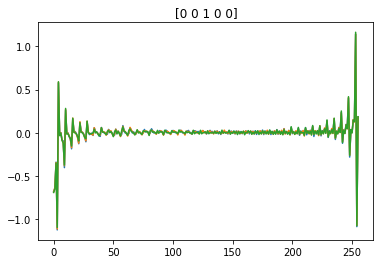

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


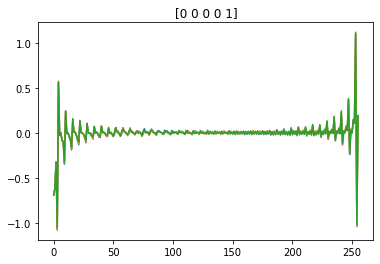

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


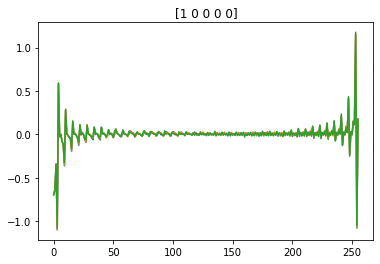

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


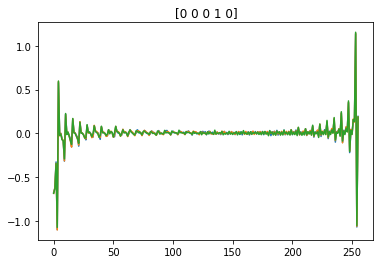

/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/azim/.local/lib/python3.6/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


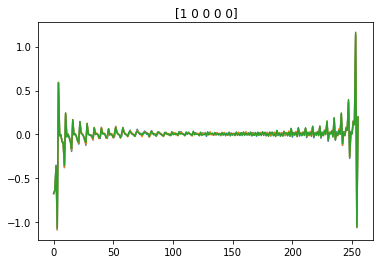

KeyboardInterrupt: 

In [41]:
num_epochs = 500
n_critic = 5
display_step = 50
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch), end=' ')
    for i, (images, labels) in enumerate(data_loader):
#         print(images.shape,labels.shape)
        
        step = epoch * len(data_loader) + i + 1
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)
#         print(d_loss)
#         print(d_loss)
        if epoch%5==0 and i%100==0:
            z = Variable(torch.randn(5, 100)).cuda()
            a = np.random.randint(0, 5, 5)
            b = np.zeros((a.size, 4+1))
            b[np.arange(a.size),a] = 1
            labels = torch.LongTensor(b).cuda()

            generator.eval()
            x_pred = generator(z, labels).unsqueeze(1).cpu().detach().numpy()*max_value
            labels = labels.cpu().detach().numpy()

            print(x_pred.shape)
            x_pred = x_pred.reshape(-1,256,6)
            print(x_pred.max())
            import matplotlib.pyplot as plt
            %matplotlib inline
            for k in range(5):
                plt.figure()
                plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
                plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
                plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
                plt.title(labels[k])
                plt.show()
            #         print(d_loss,g_loss)

In [ ]:
z = Variable(torch.randn(5, 100)).cuda()
a = np.random.randint(0, 5, 5)
b = np.zeros((a.size, 4+1))
b[np.arange(a.size),a] = 1
labels = torch.LongTensor(b).cuda()
print(z.shape,labels.shape)
# generator.eval()
# x_pred = generator(z, labels).unsqueeze(1).cpu().detach().numpy()*max_value
# labels = labels.cpu().detach().numpy()

# print(x_pred.shape)
# x_pred = x_pred.reshape(-1,256,6)

# import matplotlib.pyplot as plt
# %matplotlib inline
# for k in range(5):
#     plt.figure()
#     plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
#     plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
#     plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
#     plt.title(labels[k])
#     plt.show()

In [ ]:
z = Variable(torch.randn(50, 100)).cuda()
labels = torch.LongTensor([i for i in range(5) for _ in range(10)]).cuda()

generator.eval()
x_pred = generator(z, labels).unsqueeze(1).cpu().detach().numpy()*max_value
labels = labels.cpu().detach().numpy()

print(x_pred.shape)
x_pred = x_pred.reshape(-1,256,6)

import matplotlib.pyplot as plt
%matplotlib inline
for k in range(50):
    plt.figure()
    plt.plot(np.fft.ifft(x_pred[k][:,0]+1j*x_pred[k][:,3]))
    plt.plot(np.fft.ifft(x_pred[k][:,1]+1j*x_pred[k][:,4]))
    plt.plot(np.fft.ifft(x_pred[k][:,2]+1j*x_pred[k][:,5]))
    plt.title(labels[k])
    plt.show()

In [ ]:
generator.label_emb.weight.cpu().detach().numpy()

In [ ]:
fake_labels = 

In [ ]:
a = fake_labels

a,b

In [ ]:
torch.LongTensor(fake_labels)

In [ ]:
max_value

In [ ]:
X_fft.min()